# Statistics for Data Analytics
# Terminal Assignment-Based Assessment

#### STUDENT NAME : Dhruv Sharma
#### STUDENT ID : x22228268

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, matthews_corrcoef, precision_recall_curve, auc, log_loss

# PART A - Time Series Analysis

In [2]:
# Loading the weather dataset from the 'weather.csv' file using pandas.
# The 'date' column is parsed as datetime using the specified date format.
date_format = '%d-%b-%y'
df = pd.read_csv('weather.csv', usecols=['date', 'wdsp(Mean Wind Speed - knot)'], parse_dates=['date'], date_format=date_format)

# Setting the 'date' column as the index of the DataFrame, as it is crucial for time series analysis.
df.set_index('date', inplace=True)

# Renaming the 'wdsp(Mean Wind Speed - knot)' column as 'windspeed' for simplicity.
df.columns = ['windspeed']

# Filtering the data from 2019 to 2022 to fit the models and from 2023 to evaluate the model's performance.
df_subset = df['2019-01-01':'2023-12-31']

# Detecting and removing outliers using z-scores.
z_scores = zscore(df_subset['windspeed'])

# Any data point with a z-score greater than 3 or less than -3 is considered an outlier.
outliers_mask = (z_scores > 3) | (z_scores < -3)  

# Outliers are then removed from the dataset.
df_no_outliers = df_subset[~outliers_mask]  

# Applying Linear interpolation to fill in missing values.
df_cleaned = df_no_outliers.interpolate(method='linear')

# The frequency of the time index is explicitly set to 'D' (daily).
df_cleaned = df_cleaned.asfreq('D')

# Linear interpolation is again applied to fill any remaining gaps after setting the frequency to daily.
df_cleaned = df_cleaned.interpolate(method='linear')

# Making magnitudes for all windspeed values as positive.
df_cleaned = df_cleaned.applymap(abs)

# Displaying the last few rows of the cleaned dataset.
df_cleaned.tail()

,windspeed
date,
2023-10-27,5.8
2023-10-28,8.5
2023-10-29,5.2
2023-10-30,4.1
2023-10-31,6.8


In [3]:
# Display a statistical summary
print(df_cleaned.describe())

         windspeed
count  1765.000000
mean      8.983626
std       3.228332
min       2.600000
25%       6.500000
50%       8.500000
75%      11.200000
max      18.800000


count: There are 1765 non-null data points in the 'windspeed' variable.

mean: The mean (average) value of the 'windspeed' variable is approximately 8.98 knots.

std: The standard deviation measures the amount of variation in a set of values which is approximately 3.23 knots.

min: The minimum value of 'windspeed' in the dataset is 2.6 knots.

max: The maximum value of 'windspeed' in the dataset is 18.8 knots.

25% (Q1): 25% of the data falls below the value of approximately 6.5 knots.

50% (Q2 or Median): The median value of 'windspeed'. 50% of the data falls below the value of approximately 8.5 knots.

75% (Q3): 75% of the data falls below the value of approximately 11.2 knots.

<Figure size 1200x600 with 0 Axes>

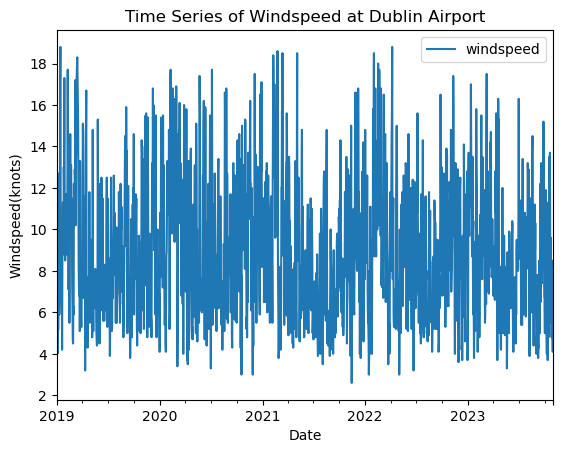

In [4]:
# The plot has a width of 12 units and a height of 6 units.
plt.figure(figsize=(12, 6))

# Plotting the time series data from the DataFrame df_cleaned.
df_cleaned.plot(title='Time Series of Windspeed at Dublin Airport')
plt.xlabel('Date')
plt.ylabel('Windspeed(knots)')
plt.show()

The above plot displays the time series of wind speed at Dublin Airport over the specified time period. 
The x-axis represents dates and the y-axis represents wind speed in knots.

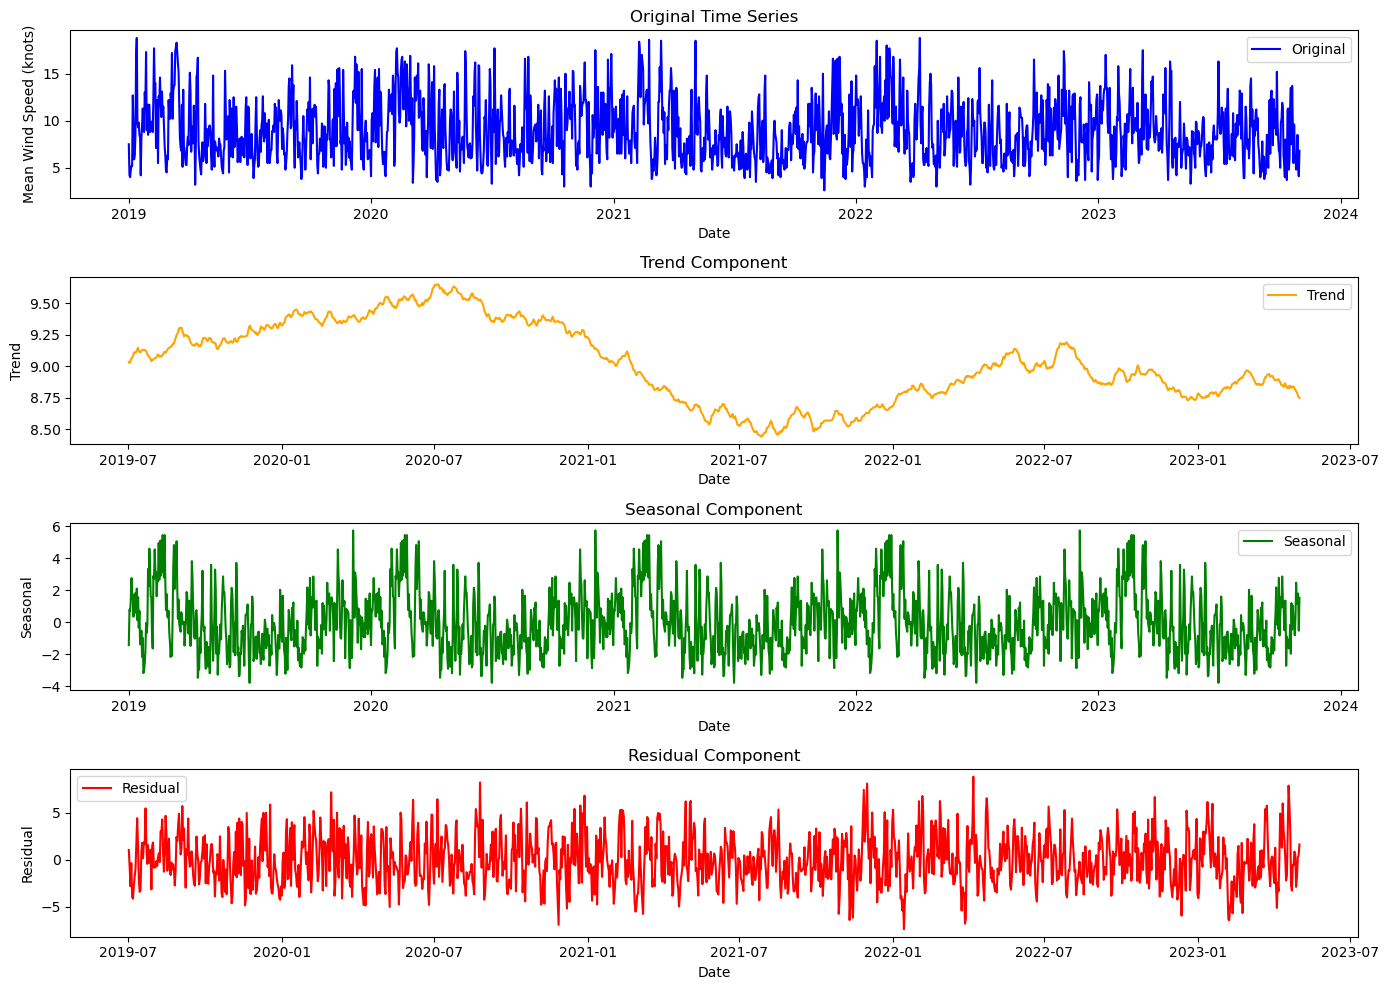

In [5]:
# Decomposing the time series in a yaerly seasonal manner using an additive model. The period=365 parameter sets a yearly seasonality.
result = seasonal_decompose(df_cleaned, model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(14, 10))

# Original time series subplot displays the original time series. 
# It plots the 'windspeed' values over time in blue.
plt.subplot(4, 1, 1)
plt.plot(df_cleaned, label='Original', color='blue')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Mean Wind Speed (knots)')
plt.legend()

# Trend subplot displays the trend component extracted from the decomposition. 
# It displays the variation in mean wind speed values over time.
plt.subplot(4, 1, 2)
plt.plot(df_cleaned.index, result.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()

# Seasonal subplot displays the seasonal component extracted from the decomposition.
# It displays the recurring pattern within each year.
plt.subplot(4, 1, 3)
plt.plot(df_cleaned.index, result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.legend()

# Residual subplot represents the unexplained variation after removing trend and seasonality.
plt.subplot(4, 1, 4)
plt.plot(df_cleaned.index, result.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()

Trend : It shows long-term variations in the windspeed. The trend component does not show a consistent long-term upward or downward trend but rather fluctuates, which indicates windspeed variations. 

Seasonal Component: The seasonal component clearly exhibits a regular pattern within each year, which is consistent with the expected seasonal variation in windspeed.

Residual Component: The residuals represents the noise after both trend and seasonality has been taken into account. It seems to fluctuate around zero without any systematic pattern. This indicates that the model has captured most of the systematic information in the data.

### Splitting the data into train and test

In [6]:
# Preparing the training and test datasets for building and evaluating time series models.
# Setting the start and end dates for the training data (2019-2022).
# The training data spans from January 1, 2019, to December 31, 2022.
train_start_date = '2019'
train_end_date = '2022'

# The test data starts from January 1, 2023.

test_start_date = '2023'

# Extracting the training data from the cleaned dataset (df_cleaned) by selecting the rows that fall within the specified date range.
train_data = df_cleaned.loc[train_start_date:train_end_date]

# Extracting the test data from the cleaned dataset (df_cleaned) starting from the specified test start date until the end of the dataset.
test_data = df_cleaned.loc[test_start_date:]

# Displaying the shapes of the training and test sets
print("Shape of training data:", train_data.shape)
print("Shape of test data:", test_data.shape)

Shape of training data: (1461, 1)
Shape of test data: (304, 1)


The author sets specific date ranges for training and test data after which extracts these subsets from the cleaned time series data. The shapes of the training and test datasets are printed for verification. This separation is crucial for training models on historical data (training set) and evaluating their performance on unseen future data (test set). This output aligns with the expected outcome, given the date ranges specified for training (2019-2022) and testing (starting from 2023). The number of rows in the training set corresponds to the number of days from January 1, 2019, to December 31, 2022, and the number of rows in the test set corresponds to the number of days from January 1, 2023, onward. The training data has a shape of (1461, 1), indicating it has 1461 rows (time points) and 1 column (feature), which is the 'windspeed' variable. The test data has a shape of (304, 1), indicating 304 rows and 1 column.

### Simple Exponential Smoothing

In [7]:
# Fitting the simple exponential smoothing model to the training data using the .fit() method.
model = SimpleExpSmoothing(train_data).fit()

# Retrieving the fitted values from the trained exponential smoothing model. 
# These values represent the model's predictions on the training data.
fitted_values = model.fittedvalues

# Retrieving the parameters of the fitted exponential smoothing model includeing the smoothing parameter alpha.
params = model.params

# Printing the result summary.
print(model.summary())
print("Smoothing parameter (alpha):", params['smoothing_level'])

                       SimpleExpSmoothing Model Results                       
Dep. Variable:              windspeed   No. Observations:                 1461
Model:             SimpleExpSmoothing   SSE                          13499.169
Optimized:                       True   AIC                           3252.544
Trend:                           None   BIC                           3263.117
Seasonal:                        None   AICC                          3252.571
Seasonal Periods:                None   Date:                 Wed, 03 Jan 2024
Box-Cox:                        False   Time:                         18:55:54
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3988560                alpha                 True
initial_level              7.5000000                

SSE (Sum of Squared Errors): SSE measures the sum of squared differences between the actual and predicted values. In this case, it's 13499.169.

AIC (Akaike Information Criterion): AIC is a measure of the model's goodness of fit, penalizing complexity. Here, it's 3252.544.

BIC (Bayesian Information Criterion): BIC is used for model selection. Here, it's 3263.117.

Trend and Seasonal: This indicates that there is no trend or seasonal component considering this is a simple exponential smoothing model.

Initial Level: The initial level is the starting value of the level component in the model. Here, it's set to 7.5.

Smoothing Parameter (alpha): The smoothing parameter alpha is a key parameter in exponential smoothing models. It controls the weight given to the most recent observation. The optimised model has an alpha value of approximately 0.399. This is the weight given to the most recent observed value. The weight given to the most recent forecast is 1-alpha or approximately 0.601. 

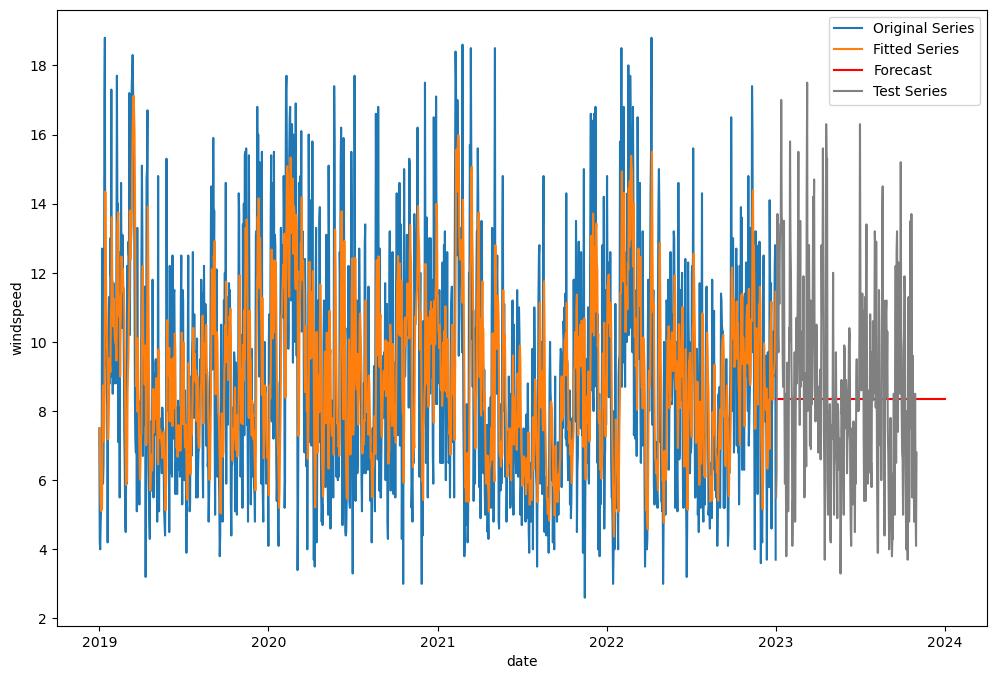

In [8]:
# Generating forecasts for the next 365 time points (daily frequency) using the fitted model.
predictions_ses = model.forecast(365)
plt.figure(figsize=(12, 8))

# Using Seaborn's lineplot to plot different series on the same plot.
sns.lineplot(x=train_data.index, y=train_data.values.flatten(), label="Original Series")
sns.lineplot(x=fitted_values.index, y=fitted_values.values, label="Fitted Series")
sns.lineplot(x=predictions_ses.index, y=predictions_ses.values, label="Forecast",color='red')
sns.lineplot(x=test_data.index, y=test_data.values.flatten(), label="Test Series",color='grey')
plt.ylabel('windspeed')
plt.show()

Seaborn's lineplot has been utilized by the author to plot the following series on the same plot:

Original Series: The original training data.

Fitted Series: The fitted values obtained from the training data.

Forecast: The forecasted values for the future.

Test Series: The actual test data.

As observed, the forecast is flat because the Simple Exponential Smoothing model is not capable of capturing the trend in the data.

In [9]:
# Printing evaluation metrics for the Simple Exponential Smoothing (SES) model.
mae_ses = mean_absolute_error(train_data, fitted_values)
rmse_ses = mean_squared_error(train_data, fitted_values)**0.5
mape_ses = mean_absolute_percentage_error(train_data, fitted_values)
print("SES - MAE = {:.3f}, RMSE = {:.3f}, MAPE = {:.3f}".format(mae_ses,rmse_ses,mape_ses))

SES - MAE = 2.416, RMSE = 3.040, MAPE = 0.300


mean_absolute_error: The Mean Absolute Error (MAE) measures the average absolute difference between the original training data (train_data) and the fitted values obtained from the SES model (fitted_values). The average absolute difference between the observed and predicted values is approximately 2.416.

mean_squared_error: The Mean Squared Error (MSE) measures the average of the squared differences between observed and predicted values. '0.5' is applied to the result to obtain the Root Mean Squared Error (RMSE), which is in the same unit as the original data. The root mean squared is approximately 3.040.

mean_absolute_percentage_error: The Mean Absolute Percentage Error (MAPE) measures the average percentage difference between the observed and predicted values. It is approximately 0.300.

### Double Exponential Smoothing
### Holt's Linear Trend

In [10]:
# Fitting double exponential smoothing model to the training data (train_data).
# Using the .fit() method to perform model fitting.
fit_holt = Holt(train_data).fit()
print(fit_holt.summary())

                              Holt Model Results                              
Dep. Variable:              windspeed   No. Observations:                 1461
Model:                           Holt   SSE                          14638.388
Optimized:                       True   AIC                           3374.913
Trend:                       Additive   BIC                           3396.060
Seasonal:                        None   AICC                          3374.971
Seasonal Periods:                None   Date:                 Wed, 03 Jan 2024
Box-Cox:                        False   Time:                         18:55:54
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5468227                alpha                 True
smoothing_trend            0.0387495                

SSE (Sum of Squared Errors): SSE measures the sum of squared differences between the actual and predicted values. In this case, it's 14638.388.

AIC (Akaike Information Criterion): AIC is a measure of the model's goodness of fit, penalizing complexity. Here, it's 3374.913.

BIC (Bayesian Information Criterion): Similar to AIC but with a stronger penalty for complexity. Here, it's 3396.060.

Trend: The trend is additive in this model.

Interpretation of Coefficients: The coefficients for the smoothing level (alpha), smoothing trend (beta), initial level (l.0), and initial trend (b.0) are displayed. These coefficients determine the behavior of the model.

smoothing_level (alpha): 0.5468227 - This controls the smoothing of the level component.

smoothing_trend (beta): 0.0387495 - This controls the smoothing of the trend component.

initial_level: 7.5000000 - The initial level at the start of the time series.

initial_trend: -3.3000000 - The initial trend at the start of the time series.

These coefficients provide insights into how much weight is given to the most recent observations and the initial values of the level and trend components.

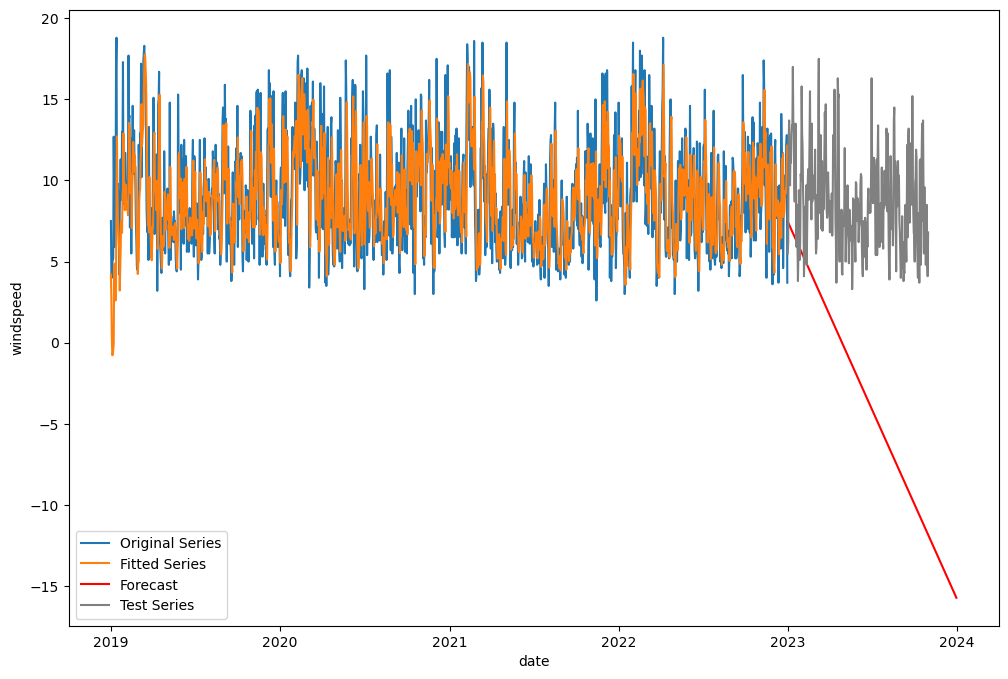

In [11]:
# Generating forecasts for the next 365 time points (daily frequency) using the fitted holt model.
predictions_holt = fit_holt.forecast(365)
plt.figure(figsize=(12, 8))

# Using Seaborn's lineplot to plot different series on the same plot.
sns.lineplot(x=train_data.index, y=train_data.values.flatten(), label="Original Series")
sns.lineplot(x=fit_holt.fittedvalues.index, y=fit_holt.fittedvalues, label="Fitted Series")
sns.lineplot(x=predictions_holt.index, y=predictions_holt.values, label="Forecast",color='red')
sns.lineplot(x=test_data.index, y=test_data.values.flatten(), label="Test Series",color='grey')
plt.ylabel('windspeed')
plt.show()

Using Seaborn's lineplot to plot the following series on the same plot:

Original Series: The original training data.

Fitted Series: The fitted values obtained from the Holt model based on the training data.

Forecast: The forecasted values for the future.

Test Series: The actual test data.

Different colors are used for better distinction between the series.

The forecast is showing a downward slope, it suggests that the double exponential smoothing (Holt) model has captured a decreasing trend in the data. Here are a few possible interpretations of a downward-sloping forecast:

Decreasing Trend: The model has identified a consistent and sustained decrease in the windspeed over time. This could be due to various factors, such as seasonal patterns, external influences, or underlying changes in the environment.

Seasonal Variation: There might be a seasonal component influencing the windspeed, leading to a periodic decrease in values.

Data Characteristics: The observed historical data might exhibit a clear downward trend, and the model has learned and captured this pattern. However, the downward trend seems inconsistent with the actual behavior of the data.

In [12]:
mae_holt = mean_absolute_error(train_data, fit_holt.fittedvalues)
rmse_holt = mean_squared_error(train_data, fit_holt.fittedvalues)**0.5
mape_holt = mean_absolute_percentage_error(train_data, fit_holt.fittedvalues)
print("SES - MAE = {:.3f}, RMSE = {:.3f}, MAPE = {:.3f}".format(mae_holt,rmse_holt,mape_holt))

SES - MAE = 2.489, RMSE = 3.165, MAPE = 0.304


MAE (Mean Absolute Error): MAE is the average absolute difference between the observed and predicted values. In this case, the average absolute difference is approximately 2.489.

RMSE (Root Mean Squared Error): RMSE measures the square root of the average squared differences between the observed and predicted values. It's in the same unit as the original data. Here, RMSE is approximately 3.165. 

MAPE (Mean Absolute Percentage Error): MAPE is the average percentage difference between the observed and predicted values. In this case, the average percentage difference is approximately 0.304. 


Interpretation:

Both models have similar performance based on the comparison of the metrics.
The SES model has slightly lower MAE and RMSE values compared to the Holt model, indicating a marginally better fit to the training data in terms of absolute and squared errors.
The MAPE values are close for both models, suggesting a comparable average percentage difference between the observed and predicted values.

### Triple Exponential Smoothing
### Holt-Winters Exponential Smoothing

In [13]:
# Fitting the Triple Exponential Smoothing model.
# With Additive trend and seasonality.
fit_tes = ExponentialSmoothing(train_data, trend="additive", seasonal="additive", seasonal_periods=365).fit()

In [14]:
print(fit_tes.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                windspeed   No. Observations:                 1461
Model:             ExponentialSmoothing   SSE                          10075.847
Optimized:                         True   AIC                           3559.220
Trend:                         Additive   BIC                           5510.078
Seasonal:                      Additive   AICC                          3812.686
Seasonal Periods:                   365   Date:                 Wed, 03 Jan 2024
Box-Cox:                          False   Time:                         18:55:56
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.3179703                alpha                 True
smoothing_trend       

The optimized model has Smoothing costant (alpha) of 0.3179703. The smoothing constant for the trend , Smoothing Trend (beta) is 1.8589e-06 and the smoothing constant for the Seasonal component (gamma) is 8.4372e-06.

Evaluation Metrics:


Sum of Squared Errors (SSE): 10075.847

Akaike Information Criterion (AIC): 3559.220

Bayesian Information Criterion (BIC): 5510.078

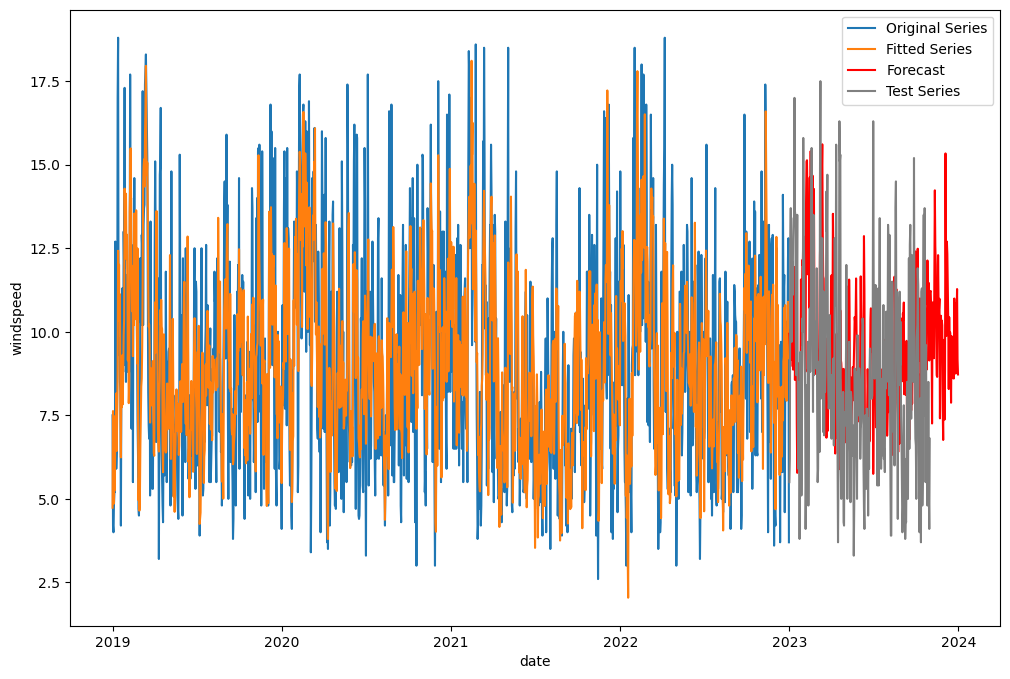

In [15]:
# Predicting the forecast for the next year - twelve periods.
predictions_tes = fit_tes.forecast(365)
plt.figure(figsize=(12, 8))

# Using Seaborn's lineplot to plot different series on the same plot.
sns.lineplot(x=train_data.index, y=train_data.values.flatten(), label="Original Series")
sns.lineplot(x=fit_tes.fittedvalues.index, y=fit_tes.fittedvalues, label="Fitted Series")
sns.lineplot(x=predictions_tes.index, y=predictions_tes.values, label="Forecast",color='red')
sns.lineplot(x=test_data.index, y=test_data.values.flatten(), label="Test Series",color='grey')
plt.ylabel('windspeed')
plt.show()

Using Seaborn's lineplot to plot the different series on the same plot:

Original Series: The original training data.

Fitted Series: The fitted values obtained from the Triple Exponential Smoothing model based on the training data.

Forecast: The forecasted values for the future.

Test Series: The actual test data.

The author essentially fits a Triple Exponential Smoothing model to the provided training data. The model includes additive components for trend and seasonality. The trend component represents the long-term movement or pattern in the data, and the seasonal component captures repeating patterns that occur at regular intervals (365, indicating a yearly cycle). From the plot, it is clear that the model has captured the trend and seasonal patterns and that the prediction is a continuation of both of these patterns.

In [16]:
mae_tes = mean_absolute_error(train_data, fit_tes.fittedvalues)
rmse_tes = mean_squared_error(train_data, fit_tes.fittedvalues)**0.5
mape_tes = mean_absolute_percentage_error(train_data, fit_tes.fittedvalues)
print("SES - MAE = {:.3f}, RMSE = {:.3f}, MAPE = {:.3f}".format(mae_tes,rmse_tes,mape_tes))

SES - MAE = 2.093, RMSE = 2.626, MAPE = 0.261


In [17]:
y_true = test_data.values.flatten()
predictions_tes_trimmed = predictions_tes[:len(y_true)]
# Calculating the metrics for predictions.
mae_forecast = mean_absolute_error(y_true, predictions_tes_trimmed)
rmse_forecast = mean_squared_error(y_true, predictions_tes_trimmed)**0.5
mape_forecast = mean_absolute_percentage_error(y_true, predictions_tes_trimmed)
print("SES - MAE = {:.3f}, RMSE = {:.3f}, MAPE = {:.3f}".format(mae_forecast,rmse_forecast,mape_forecast))

SES - MAE = 2.791, RMSE = 3.442, MAPE = 0.381


The model appears to perform better on the training data (lower MAE, RMSE, and MAPE) than on the test data.
This discrepancy between training and test metrics indicates potential overfitting, where the model fits the training data too closely and does not generalize well to new, unseen data.

### ARIMA
### Autoregressive Integrated Moving Average Model

Checking for stationarity using the Augmented Dickey-Fuller test. The hypotheses for this test are:

In [18]:
adfuller(train_data["windspeed"])

(-12.577009514445939,
 1.947416179854571e-23,
 4,
 1456,
 {'1%': -3.43484922137066,
  '5%': -2.8635271063560412,
  '10%': -2.5678279184465946},
 7076.3854435093035)

In [19]:
# Augmented Dickey-Fuller test
adf_result = adfuller(df_cleaned)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -17.214502635144125
p-value: 6.33762822187217e-30


In summary, the low p-value and highly negative test statistic is indicative to reject the null hypothesis. The author rejects the null hypothesis under 95% confidence level since the p-value is less than 0.05 and accept the alternate hypothesis H1 that the time series is stationary. There is no change in the mean or variance over time. This implies that the "windspeed" data is likely stationary.

<Axes: xlabel='date'>

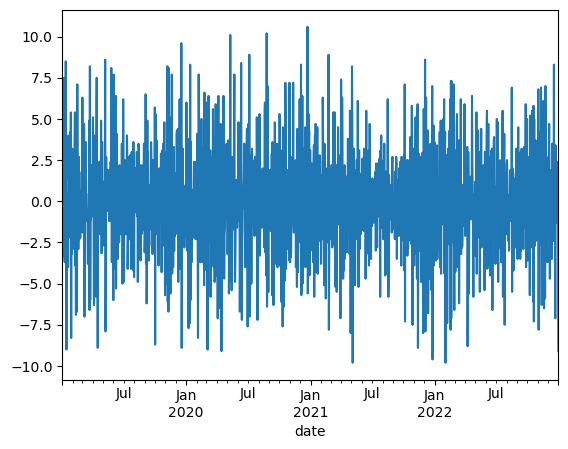

In [20]:
# Applying first difference and plotting its impact on stationarity. 
FirstDifference = (train_data["windspeed"] - train_data["windspeed"].shift(1)).dropna()
FirstDifference.plot()

In [21]:
# Applying Augmented Dickey-Fuller test to check if the above series is stationary.
round(adfuller(FirstDifference)[1],3)

0.0

As the p value is less than 0.001, the author rejects null hypothesis and conclude that the first differenced series is stationary.

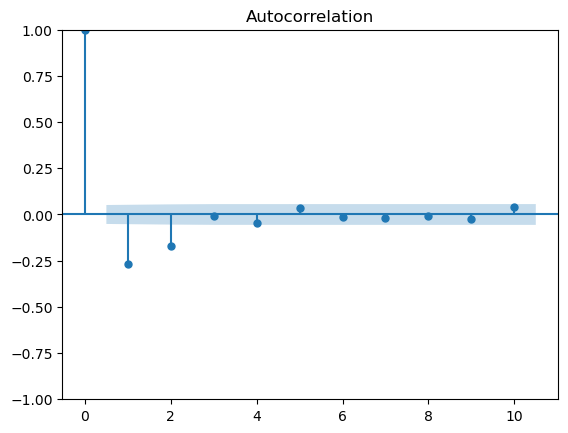

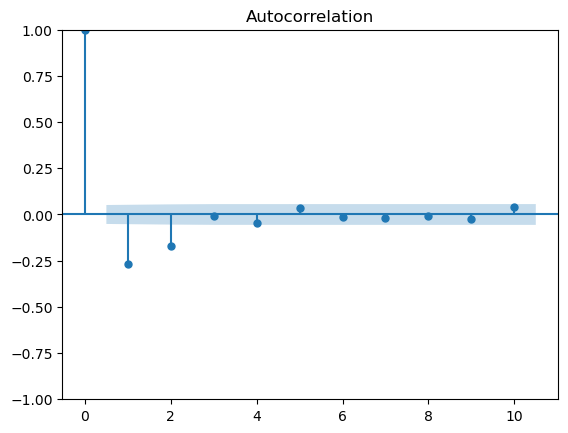

In [22]:
# Generating the Autocorrelation Function (ACF) plot.
plot_acf(FirstDifference,lags=10)

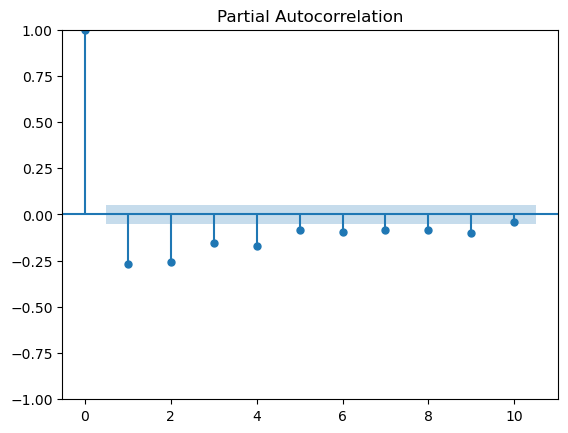

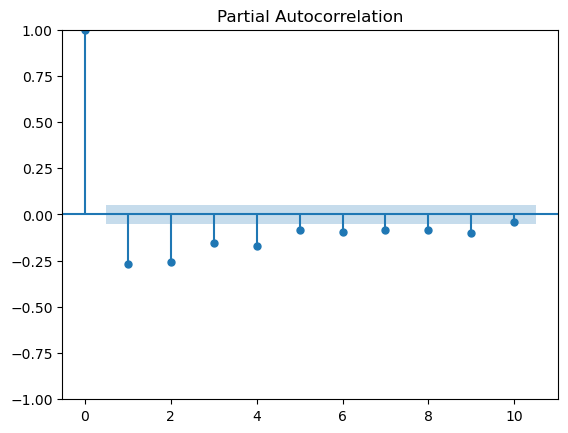

In [23]:
# Generating the Partial Autocorrelation Function (PACF) plot.
plot_pacf(FirstDifference,lags=10)

The ACF plot shows the autocorrelation of the time series with itself at different lags by identifying the order of the Moving Average (MA) component of the ARIMA model.

The PACF plot shows the partial autocorrelation of the time series with itself at different lags by identifying the order of the AutoRegressive (AR) component of the ARIMA model.

So, an ARIMA model with AR(3) refers that it has a linear dependence on the three most recent past values of the time series. The full notation for such a model ARIMA(p, d, q), where:

p is the order of the AutoRegressive (AR) component.

d is the degree of differencing (number of times the series is differenced to achieve stationarity).

q is the order of the Moving Average (MA) component.

### Fitting the ARIMA Model

In [24]:
# Finding the best-fitting ARIMA model based on the Akaike Information Criterion (AIC).
# Defining a list of ARIMA model orders to fit.
model_orders = [
    (2, 1, 0),
    (2, 1, 1),
    (2, 1, 2),
    (3, 1, 0),
    (3, 1, 1),
    (3, 1, 2),
    (4, 1, 0),
    (4, 1, 1),
    (4, 1, 2),
    (1, 0, 2),
    (0, 0, 0),
]

# Storing the models and determining their respective AIC values.
models_aic = {}

# Looping each order model and storing its AIC value.
# Checking AIC values to find the best fit.
for order in model_orders:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        models_aic[order] = model_fit.aic
        print(f'ARIMA{order} AIC: {model_fit.aic}')
    except Exception as e:
        print(f'Failed to fit ARIMA{order}: {e}')

# Finding the model with the lowest AIC value.
best_aic = min(models_aic, key=models_aic.get)
print(f'Best model: ARIMA{best_aic} with AIC: {models_aic[best_aic]}')

ARIMA(2, 1, 0) AIC: 7422.490450501318
ARIMA(2, 1, 1) AIC: 7211.4881750623135
ARIMA(2, 1, 2) AIC: 7210.604674861082
ARIMA(3, 1, 0) AIC: 7388.198182798067
ARIMA(3, 1, 1) AIC: 7208.066825307509
ARIMA(3, 1, 2) AIC: 7209.596976520272
ARIMA(4, 1, 0) AIC: 7347.95717552935
ARIMA(4, 1, 1) AIC: 7210.059360179487
ARIMA(4, 1, 2) AIC: 7211.614636272852
ARIMA(1, 0, 2) AIC: 7205.62585193193
ARIMA(0, 0, 0) AIC: 7628.383730107262
Best model: ARIMA(1, 0, 2) with AIC: 7205.62585193193


In [25]:
# Using the auto_arima function to automatically select the best-fitting ARIMA model.
auto_arima(train_data["windspeed"])

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True)

Lower AIC values indicated a better trade-off between model fit and complexity. The best-fitting model has been identified to be ARIMA(1, 0, 2) which has an AIC value of 7205.63.

ARIMA(1,0,2): This represents the main ARIMA components.

(1,0,2) indicates that the model has an AutoRegressive (AR) order of 1 (p=1), no differencing (d=0), and a Moving Average (MA) order of 2 (q=2). This inferences that the model includes the first lag of the series in the AR component, no differencing, and the first two lags of the forecast errors in the MA component.

In [26]:
model102 =ARIMA(train_data["windspeed"], order=(1,0,2))
fit102 = model102.fit()
print(fit102.summary())

                               SARIMAX Results                                
Dep. Variable:              windspeed   No. Observations:                 1461
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3597.813
Date:                Wed, 03 Jan 2024   AIC                           7205.626
Time:                        18:56:11   BIC                           7232.060
Sample:                    01-01-2019   HQIC                          7215.487
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0469      0.197     45.850      0.000       8.660       9.434
ar.L1          0.7698      0.054     14.361      0.000       0.665       0.875
ma.L1         -0.2861      0.060     -4.755      0.0

The model captures a constant term (intercept) of approximately 9.0469. The autoregressive term at lag 1 (AR coefficient) is 0.7698, indicating a positive influence of the previous value on the current value. The moving average terms at lags 1 and 2 (MA coefficients) are -0.2861 and -0.1628, respectively, suggesting the impact of past error terms on the current value. The residuals have a variance (sigma2) of 8.0599. Diagnostic tests indicate no significant autocorrelation in residuals (Ljung-Box Q test) and normality concerns (Jarque-Bera test).Additionally, Heteroskedasticity test indicates homoskedasticity (p-value > 0.05).The skewness of residuals is 0.50, suggesting a moderate asymmetry.

In terms of goodness of fit and model selection, the log likelihood is -3597.813, and the AIC is 7205.626, both suggesting a reasonably good fit. Thus, the model parameters are statistically significant based on p-values. The SARIMAX model (1, 0, 2) provides a satisfactory fit to the windspeed data. Model coefficients are statistically significant, and diagnostics suggest no significant issues, though potential non-normality in residuals should be considered. This model can be used for forecasting future windspeed values with reasonable confidence.

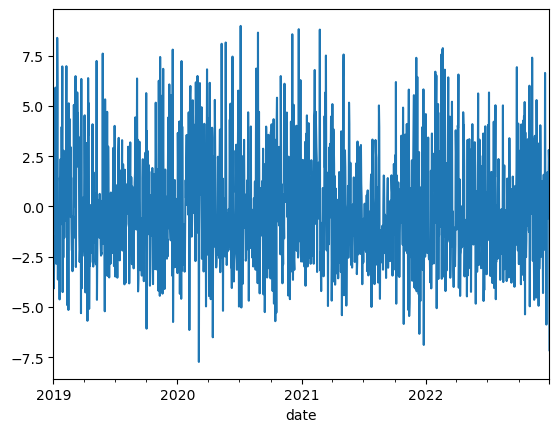

In [27]:
# Examining if the residuals exhibit any patterns or significant deviations from white noise.
fit102.resid.plot()
plt.show()

In [28]:
# Checking for serial correlation in the residuals by Ljung-Box test.
acorr_ljungbox(fit102.resid,lags=10)

,lb_stat,lb_pvalue
1,0.000035,0.995311
2,0.010044,0.994990
3,0.022129,0.999130
4,0.989232,0.911424
5,2.567891,0.766238
6,2.701454,0.845276
7,2.882166,0.895685
8,2.901105,0.940410
9,3.146257,0.958213
10,4.894501,0.898113


The p value is not significant, indicating that there is no strong evidence of serial correlation in the residuals up to lag 10.Thus, the model is capable of adequately capturing the temporal dependencies in the data.

### Evaluating ARIMA Model 102

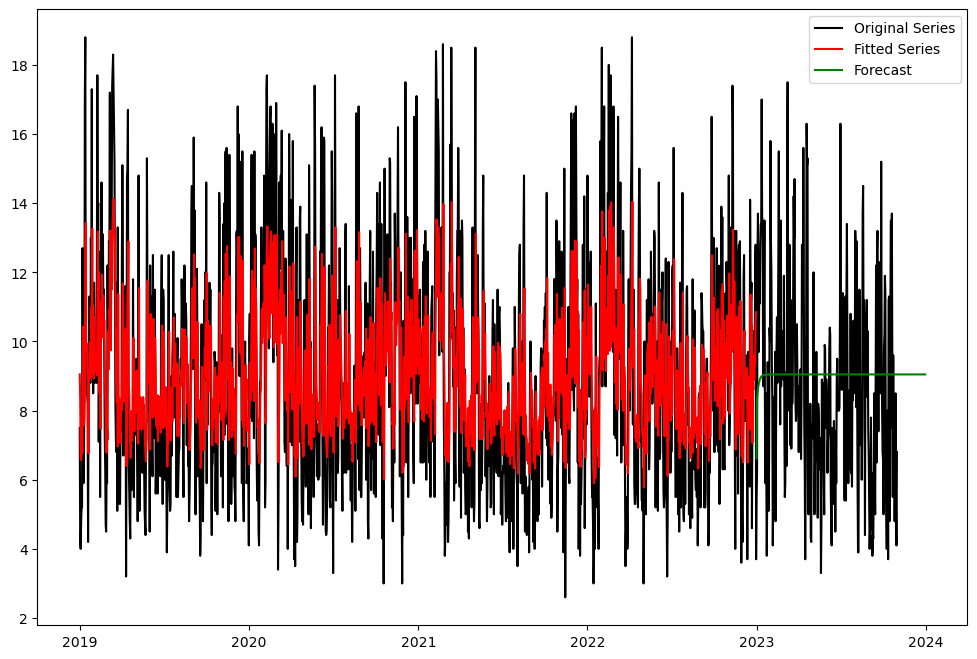

In [29]:
# Generating predictions for the next 365 steps (days) based on the fitted ARIMA(1, 0, 2) model using the forecast method.
predictions_102 = fit102.forecast(365)

plt.figure(figsize=(12, 8))
# Ploting the original series, smoothed series, and forecast
plt.plot(df_cleaned, color="black", label="Original Series")
plt.plot(fit102.fittedvalues, color="red", label="Fitted Series")
plt.plot(predictions_102, color="green", label="Forecast")
plt.legend()
plt.show()

Since ARIMA forecasts are mean reverting, as higher forecast horizon indicates that the forecasted values converge or approach the mean (average) of the time series. The ARIMA model produced a flat curve.

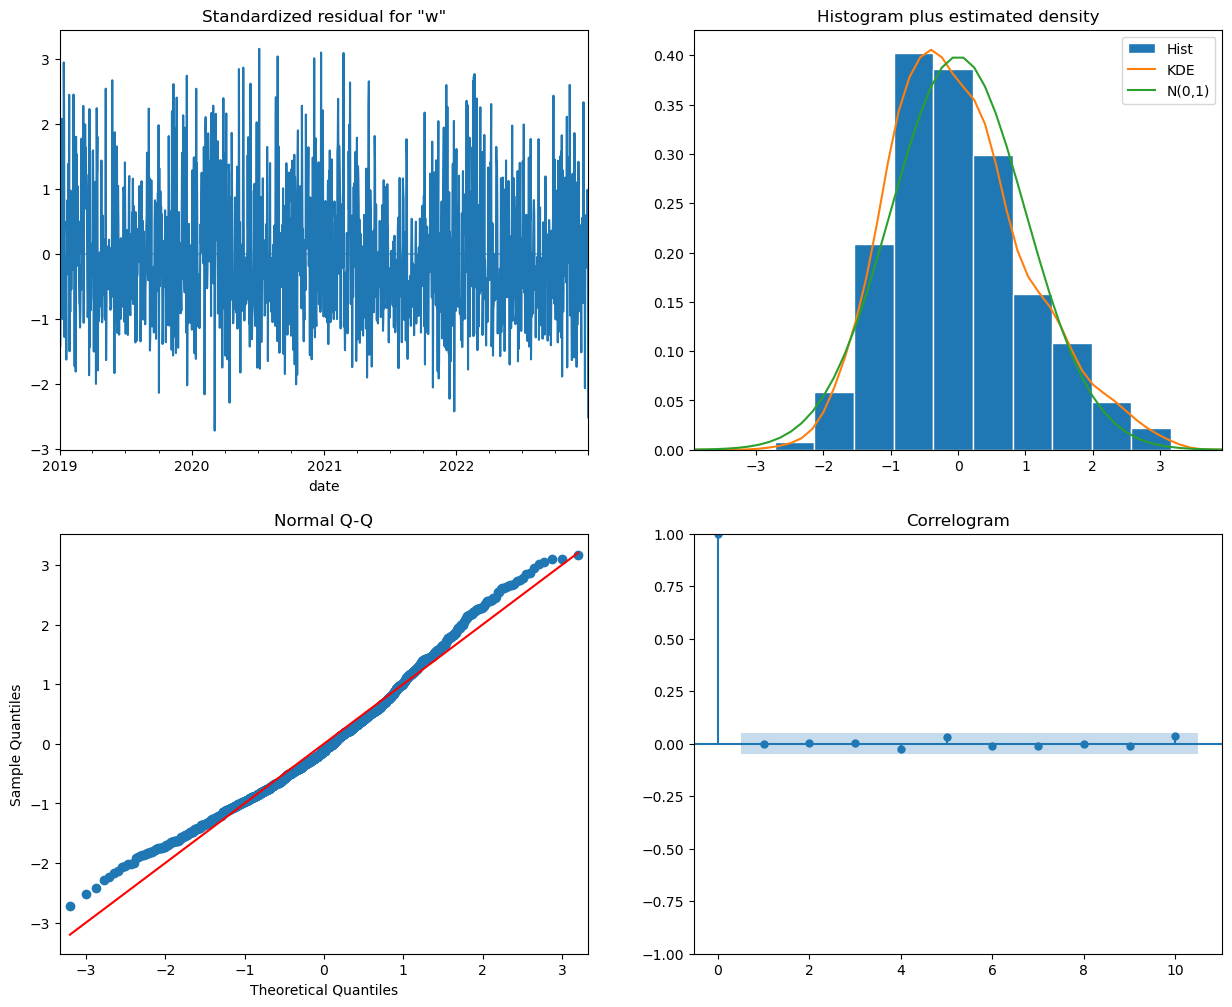

In [30]:
# Generating a set of diagnostic plots to assess the goodness of fit of the model.
fit102.plot_diagnostics(figsize=(15, 12))
plt.show()

1. Top-left plot (Residuals vs. Observed): This plot compares the residuals (the differences between observed and predicted values) against the observed values to identify patterns or trends in the residuals.

2. Top-right plot (Kernel Density Estimate): This plot is a kernel density estimate of the residuals. It provides an estimate of the probability density function of the residuals.

3. Bottom-left plot (Normal Q-Q): The Normal Q-Q (quantile-quantile) plot compares the distribution of the residuals against a theoretical normal distribution. The points lie approximately along the diagonal line, indicating that the residuals follow a normal distribution.

4. Bottom-right plot (Correlogram or Autocorrelation): This plot shows the autocorrelation of the residuals at different lags to identify any remaining patterns or serial correlation in the residuals.

In [31]:
# Forecasting using the ARIMA(1,0,2) model
forecast_102 = fit102.get_forecast(steps=len(test_data))
forecast_values_102 = forecast_102.predicted_mean
forecast_ci_102 = forecast_102.conf_int()

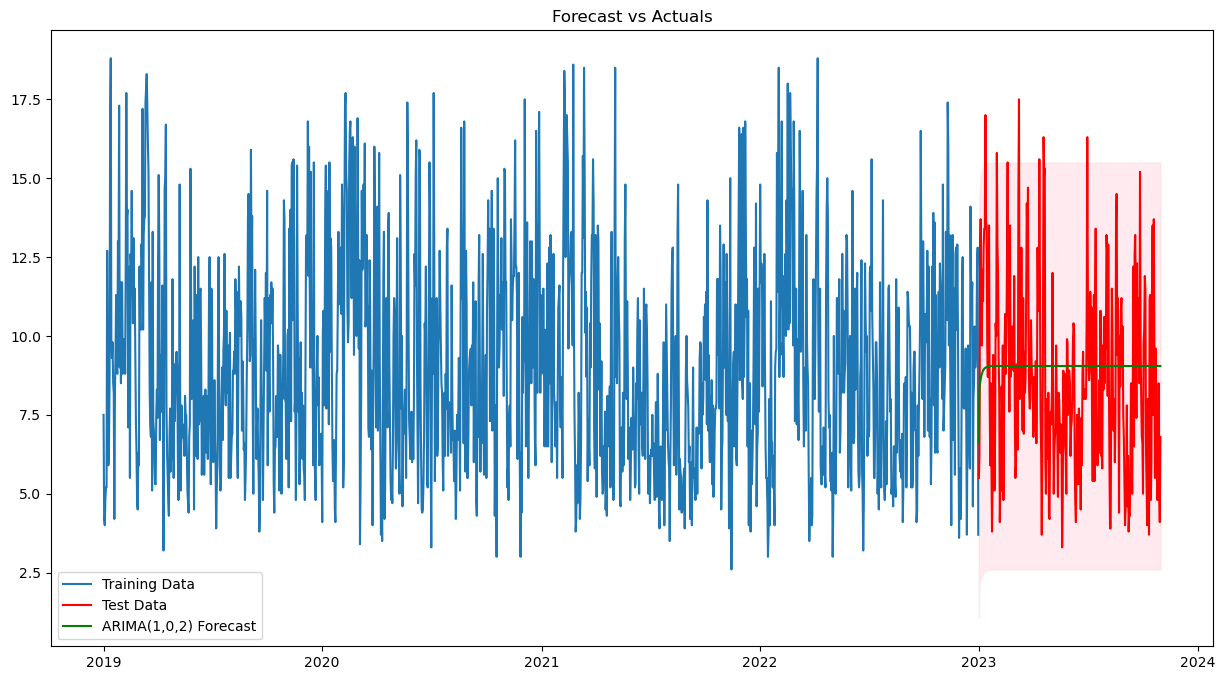

In [32]:
# Plotting the forecast alongside the actual data.
plt.figure(figsize=(15, 8))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')
plt.plot(forecast_values_102, label='ARIMA(1,0,2) Forecast', color='green')
plt.fill_between(forecast_ci_102.index,
                 forecast_ci_102.iloc[:, 0],
                 forecast_ci_102.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

This plot provides a visual comparison between the actual test data, the training data, and the forecasted values from the ARIMA(1,0,2) model. The shaded area around the forecasted values represents the confidence intervals, indicating the range of uncertainty associated with the predictions. The blue line represents the historical training data used to fit the model, capturing the variability and trend of the windspeed over time. The red line depicts the test data, which is the true values that occurred during the forecast period. The green line represents the forecasted values generated by the ARIMA(1,0,2) model, and the shaded area shows the 95% confidence interval for the forecast.

The model appears to capture the overall trend and seasonality in the historical data well, as evidenced by the close alignment of the green forecast line with the blue historical data line. The green forecast line lies within the range of the actual test data, indicating that the model's predictions are reasonable and within expected variability.

In [33]:
mae102 = mean_absolute_error(train_data, fit102.fittedvalues)
rmse102 = mean_squared_error(train_data, fit102.fittedvalues)**0.5
mape102 = mean_absolute_percentage_error(train_data, fit102.fittedvalues)
print("ARIMA(1,0,2) - MAE:{:.3f}, RMSE:{:.3f}, MAPE:{:.3f}".format(mae102,rmse102,mape102))

ARIMA(1,0,2) - MAE:2.269, RMSE:2.839, MAPE:0.285


In [34]:
# Calculate forecast accuracy metrics
mae = mean_absolute_error(test_data, forecast_values_102)
rmse = mean_squared_error(test_data, forecast_values_102, squared=False)
print(f'ARIMA(1,0,2) - MAE: {mae:.3f}, RMSE: {rmse:.3f}')

ARIMA(1,0,2) - MAE: 2.382, RMSE: 2.921


In this analysis, the employed an ARIMA(1,0,2) model to forecast wind speed based on historical data. The model demonstrated promising performance on both the training and test datasets, as evidenced by various accuracy metrics.

These metrics collectively indicate that the ARIMA(1,0,2) model provided reasonably accurate predictions for wind speed. The lower values of MAE and RMSE infers that the model's forecasts closely align with the actual observations. Additionally, the MAPE values indicate that, on average, the model's predictions deviate by approximately 0.285% and 2.921% from the actual values on the training and test datasets, respectively.

In conclusion, the ARIMA(1,0,2) model serves as a valuable tool for wind speed forecasting, demonstrating commendable accuracy in this analysis. Continued monitoring, periodic model updates, and consideration of external factors may enhance the model's performance in real-world applications.

#  PART B – Logistic Regression

In [35]:
# Loading the dataset.
df = pd.read_csv('cardiac.csv')

In [36]:
# Displaying the first few rows of the dataset.
print(df.head())

   caseno  age  weight  gender  fitness_score cardiac_condition
0       1   37   70.47    Male          55.79            Absent
1       2   73   50.34  Female          35.00            Absent
2       3   46   87.65    Male          42.93           Present
3       4   36   89.80  Female          28.30           Present
4       5   34  103.02    Male          40.56            Absent


In [37]:
# Descriptive statistics
print(df.describe())

           caseno        age      weight  fitness_score
count  100.000000  100.00000  100.000000     100.000000
mean    50.500000   41.10000   79.660300      43.629800
std     29.011492    9.14253   15.089842       8.571306
min      1.000000   30.00000   50.000000      27.350000
25%     25.750000   34.00000   69.732500      36.595000
50%     50.500000   39.00000   79.240000      42.730000
75%     75.250000   45.25000   89.912500      49.265000
max    100.000000   74.00000  115.420000      62.500000


In [38]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   caseno             100 non-null    int64  
 1   age                100 non-null    int64  
 2   weight             100 non-null    float64
 3   gender             100 non-null    object 
 4   fitness_score      100 non-null    float64
 5   cardiac_condition  100 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 4.8+ KB
None


C:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


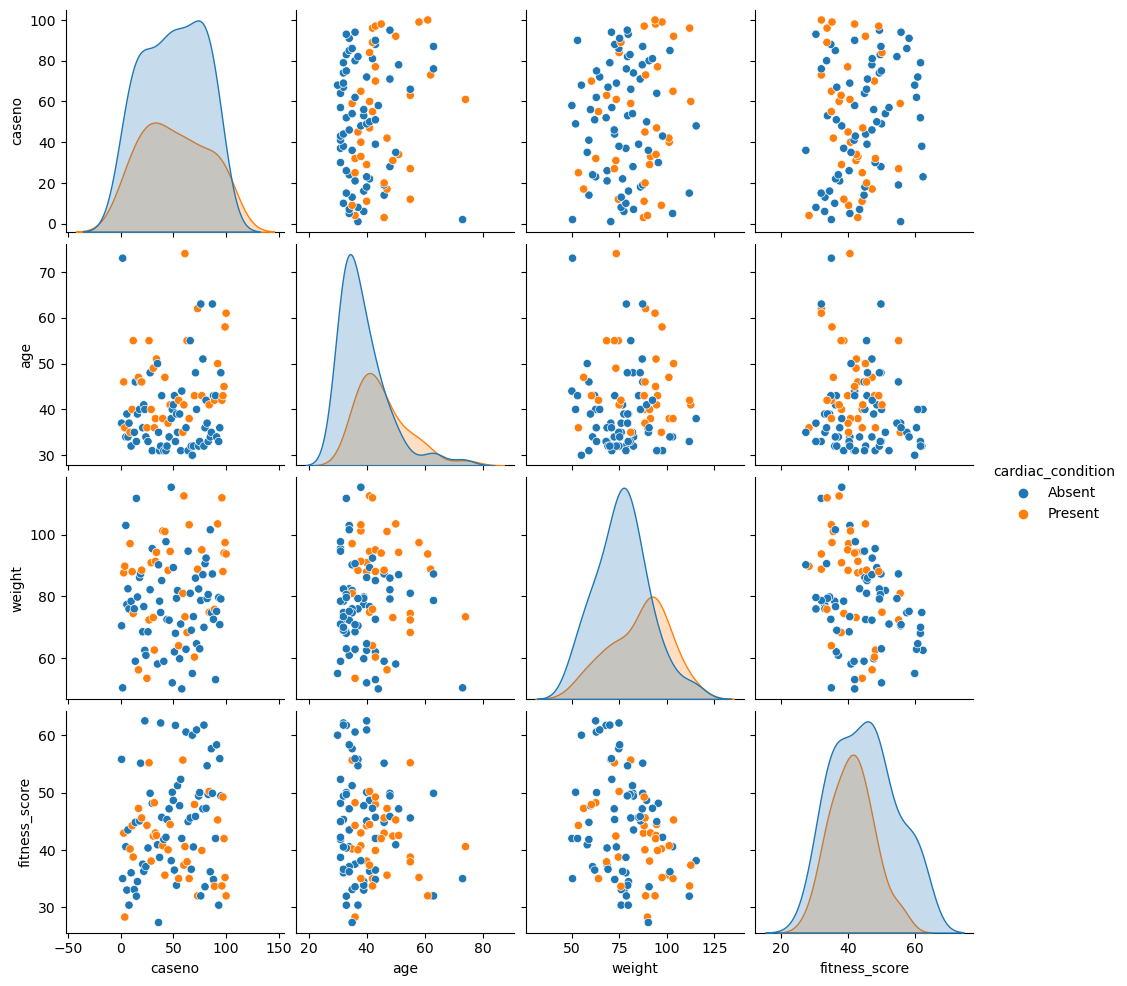

In [39]:
# Generating visualization to explore relationships between different variables
sns.pairplot(df, hue='cardiac_condition')
plt.show()

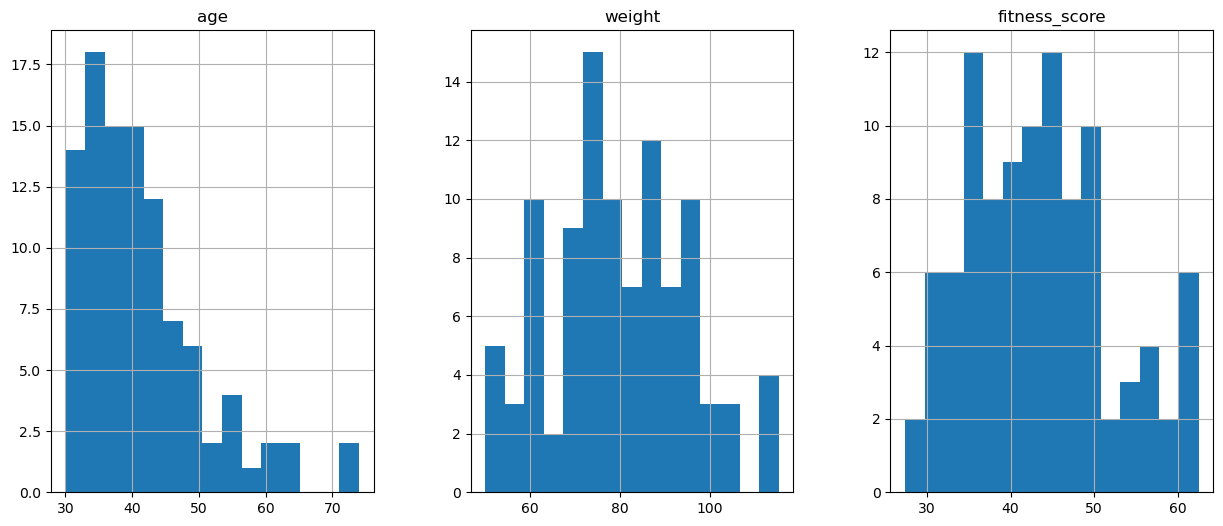

In [40]:
# Generating histograms for continuous variables.
df[['age', 'weight', 'fitness_score']].hist(bins=15, figsize=(15, 6), layout=(1, 3))
plt.show()

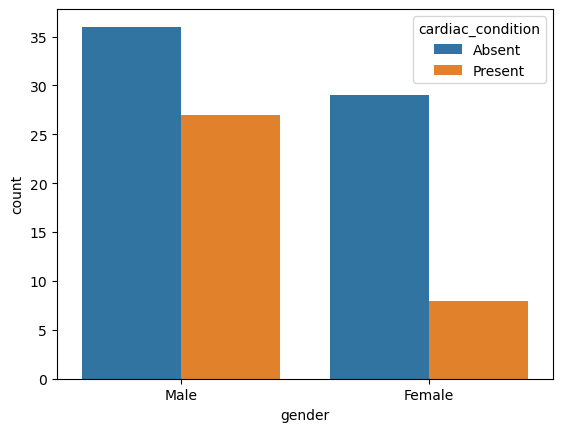

In [41]:
# Visualizing the relationship between categorical variable 'gender' and the target variable 'cardiac_condition'.
sns.countplot(x='gender', hue='cardiac_condition', data=df)
plt.show()

In [42]:
# Encoding the categorical variables 'gender' and 'cardiac_condition'.
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['cardiac_condition'] = le.fit_transform(df['cardiac_condition'])

In [43]:
# Verifying the mapping.
print(df.head())

   caseno  age  weight  gender  fitness_score  cardiac_condition
0       1   37   70.47       1          55.79                  0
1       2   73   50.34       0          35.00                  0
2       3   46   87.65       1          42.93                  1
3       4   36   89.80       0          28.30                  1
4       5   34  103.02       1          40.56                  0


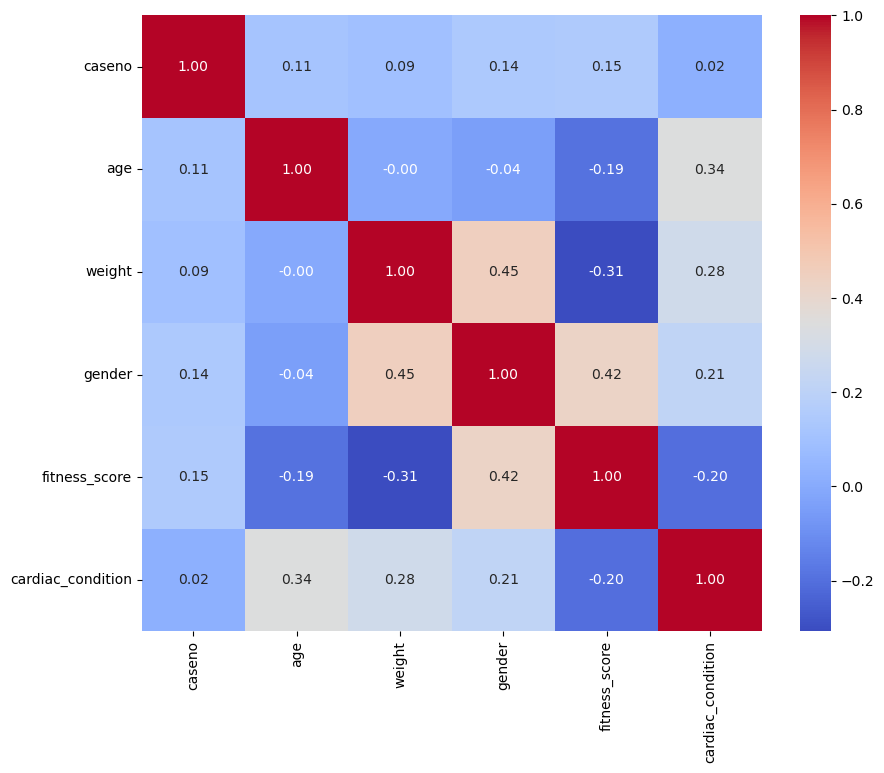

In [44]:
# Plotting the Correlation matrix for feature selection.
correlation_matrix = df.corr()

# Plotting the correlation matrix using seaborn.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [45]:
# Splitting the data into training and testing sets.
# Setting the random seed as 22228268.
np.random.seed(22228268)  
train, test = train_test_split(df, test_size=0.2, random_state=22228268)

## Model 1

In [46]:
# Selecting features for model building.
X_train = train[['age', 'weight', 'gender', 'fitness_score']]
y_train = train['cardiac_condition']
X_test = test[['age', 'weight', 'gender', 'fitness_score']]
y_test = test['cardiac_condition']

In [47]:
# Standardizing the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
# Fitting the logistic regression model.
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

LogisticRegression()

In [49]:
# Evaluating the model on training set.
train_predictions = log_reg.predict(X_train_scaled)
print("Classification Report on Training Set:\n", classification_report(y_train, train_predictions))
print("Confusion Matrix on Training Set:\n", confusion_matrix(y_train, train_predictions))

Classification Report on Training Set:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83        52
           1       0.70      0.57      0.63        28

    accuracy                           0.76        80
   macro avg       0.74      0.72      0.73        80
weighted avg       0.76      0.76      0.76        80

Confusion Matrix on Training Set:
 [[45  7]
 [12 16]]


In [50]:
# Evaluating the model on the test set.
test_predictions = log_reg.predict(X_test_scaled)
print("Classification Report on Test Set:\n", classification_report(y_test, test_predictions))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, test_predictions))

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.40      0.57      0.47         7

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
weighted avg       0.59      0.55      0.56        20

Confusion Matrix on Test Set:
 [[7 6]
 [3 4]]


In [51]:
# Applying Logistic Regression using statsmodels for detailed statistics
X_train_sm = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.459799
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      cardiac_condition   No. Observations:                   80
Model:                          Logit   Df Residuals:                       75
Method:                           MLE   Df Model:                            4
Date:                Wed, 03 Jan 2024   Pseudo R-squ.:                  0.2898
Time:                        18:56:24   Log-Likelihood:                -36.784
converged:                       True   LL-Null:                       -51.796
Covariance Type:            nonrobust   LLR p-value:                 4.840e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8281      0.301     -2.748      0.006      -1.419      -0.237
x1             1.1976      0.

In [52]:
X_train_scaled.shape

(80, 4)

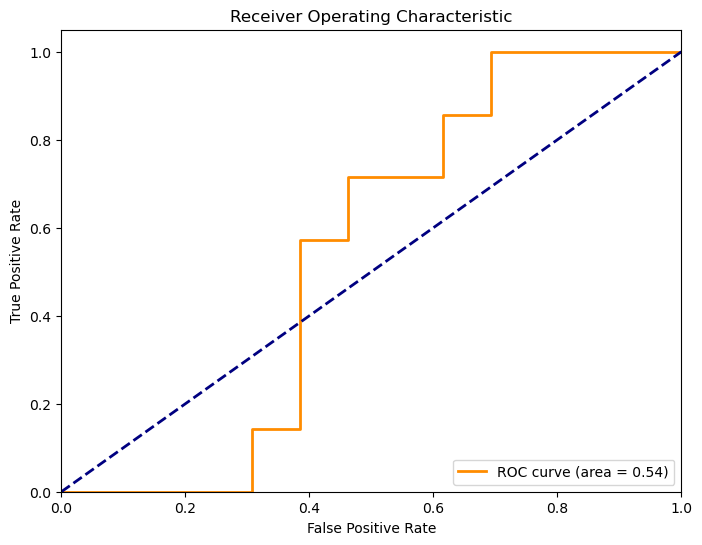

In [53]:
log_reg.fit(X_train_scaled, y_train)

# After fitting the model, getting the probability estimates.
y_pred_proba = log_reg.predict_proba(X_test_scaled)

# Computing ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Plotting the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [54]:
# Checking feature importance in the logistic regression model.
importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(log_reg.coef_[0])})
importance = importance.sort_values(by='Importance', ascending=False)
print(importance)

         Feature  Importance
0            age    1.052112
1         weight    0.706170
2         gender    0.455281
3  fitness_score    0.262047


The logistic regression model demonstrates meaningful predictive power, meeting relevant assumptions as indicated by the pseudo R-squared value of 28.98%. Key predictors such as age, weight, and gender play crucial roles in predicting the likelihood of cardiac conditions. Ongoing monitoring and potential refinement of the model may enhance its utility in healthcare decision-making.

In [55]:
# Predicting on the test set with the statsmodels model
X_test_scaled = sm.add_constant(X_test_scaled)
y_pred_sm = result.predict(X_test_scaled)
y_pred_binary_sm = (y_pred_sm > 0.5).astype(int)  # Convert probabilities to binary predictions.

# Calculating accuracy with statsmodels model
accuracy_sm = accuracy_score(y_test, y_pred_binary_sm)

# Generating a confusion matrix with statsmodels model
conf_matrix_sm = confusion_matrix(y_test, y_pred_binary_sm)

# Generating a classification report with statsmodels model
report_sm = classification_report(y_test, y_pred_binary_sm, zero_division=1)   

# Printing the evaluation results with statsmodels model
print(f'Accuracy (Statsmodels Model): {accuracy_sm}')
print(f'Confusion Matrix (Statsmodels Model):\n{conf_matrix_sm}')
print(f'Classification Report (Statsmodels Model):\n{report_sm}')

Accuracy (Statsmodels Model): 0.55
Confusion Matrix (Statsmodels Model):
[[7 6]
 [3 4]]
Classification Report (Statsmodels Model):
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.40      0.57      0.47         7

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
weighted avg       0.59      0.55      0.56        20



The model exhibits challenges in predicting instances of class 0, possibly due to an imbalanced dataset. The performance for class 1 is relatively better, with the model capturing all instances but with moderate precision.

## Model 2

In [56]:
#Applying Regularization Techniques.
# Lasso Regularization
lasso_logreg = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=1000, random_state=22228268)
lasso_logreg.fit(X_train, y_train)

# Ridge Regularization
ridge_logreg = LogisticRegressionCV(cv=5, penalty='l2', max_iter=1000, random_state=22228268)
ridge_logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, random_state=22228268)

In [57]:
# Evaluating Lasso Regularized Model.
y_pred_lasso = lasso_logreg.predict(X_test)
print('Lasso Regularization Model Accuracy:', accuracy_score(y_test, y_pred_lasso))
print(confusion_matrix(y_test, y_pred_lasso))
print(classification_report(y_test, y_pred_lasso))

# Evaluating Ridge Regularized Model.
y_pred_ridge = ridge_logreg.predict(X_test)
print('Ridge Regularization Model Accuracy:', accuracy_score(y_test, y_pred_ridge))
print(confusion_matrix(y_test, y_pred_ridge))
print(classification_report(y_test, y_pred_ridge))

Lasso Regularization Model Accuracy: 0.6
[[8 5]
 [3 4]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.44      0.57      0.50         7

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.63      0.60      0.61        20

Ridge Regularization Model Accuracy: 0.55
[[9 4]
 [5 2]]
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.33      0.29      0.31         7

    accuracy                           0.55        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.53      0.55      0.54        20



In [58]:
# Assuming you've already fitted the model
lasso_logreg.fit(X_train, y_train)

# Accessing the coefficients and intercept
coefficients = lasso_logreg.coef_
intercept = lasso_logreg.intercept_

# Displaying the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[ 0.09964723  0.02125755  1.52486052 -0.0817112 ]]
Intercept: [-3.91491868]


**Interpretation:**
- Both models exhibit moderate performance.
- The Lasso model achieved a higher accuracy (60%) compared to the Ridge model (55%).
- In the Lasso model, precision is higher for class 0, but recall is higher for class 1. This indicates a trade-off between precision and recall.
- The Ridge model has similar precision for both classes but lower overall accuracy.

The logistic regression model 2 indicates a pseudo R-squared of 23.48%, suggesting a moderate level of explained variability. The intercept term is undefined (nan), potentially indicating issues with perfect separation or multicollinearity. 

## Model 3

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = df[['age', 'weight', 'gender', 'fitness_score']]
y = df['cardiac_condition'].values.ravel()  

# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying PCA.
n_components = 4 
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fitting a logistic regression model on the reduced data.
model = LogisticRegression()
model.fit(X_train_pca, y_train)
model.fit(X_train_pca, y_train.ravel())  

# Predicting on the test set.
predictions = model.predict(X_test_pca)

# Evaluating the model.
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.60      0.38      0.46         8

    accuracy                           0.65        20
   macro avg       0.63      0.60      0.60        20
weighted avg       0.64      0.65      0.63        20



Precision: Precision measures the accuracy of positive predictions. For class 0, the precision is 0.67, indicating that 67% of the predicted instances as class 0 are indeed true class 0. For class 1, the precision is 0.60, meaning that 60% of the predicted instances as class 1 are correct.

Recall (Sensitivity): Recall measures the ability of the model to capture all the positive instances. For class 0, the recall is 0.83, indicating that 83% of the actual instances of class 0 are correctly identified. For class 1, the recall is 0.38, suggesting that only 38% of the actual instances of class 1 are captured by the model.

F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.74, and for class 1, it is 0.46.

Accuracy: The overall accuracy of the model is 65%, meaning that 65% of the predictions across both classes are correct.

Macro Avg and Weighted Avg: These metrics provide the average performance across classes. The macro-average gives equal weight to each class, while the weighted average considers the class imbalance. In this case, the macro-average F1-score is 0.60, and the weighted average F1-score is 0.63.

Interpretation:

The model 3 performs reasonably well in identifying instances of class 0, as indicated by high precision and recall.
However, the model struggles to identify instances of class 1, as reflected in the lower recall and F1-score for class 1.
The weighted average F1-score provides an overall assessment, considering both classes and accounting for any class imbalance.

In [60]:
# Predicted probabilities
y_prob = model.predict_proba(X_test_pca)[:, 1]

# Evaluating the model.
print(classification_report(y_test, predictions))

# Precision-Recall Curve.
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.60      0.38      0.46         8

    accuracy                           0.65        20
   macro avg       0.63      0.60      0.60        20
weighted avg       0.64      0.65      0.63        20



Confusion Matrix:
[[10  2]
 [ 5  3]]
Cohen's Kappa: 0.22
Matthews Correlation Coefficient: 0.24


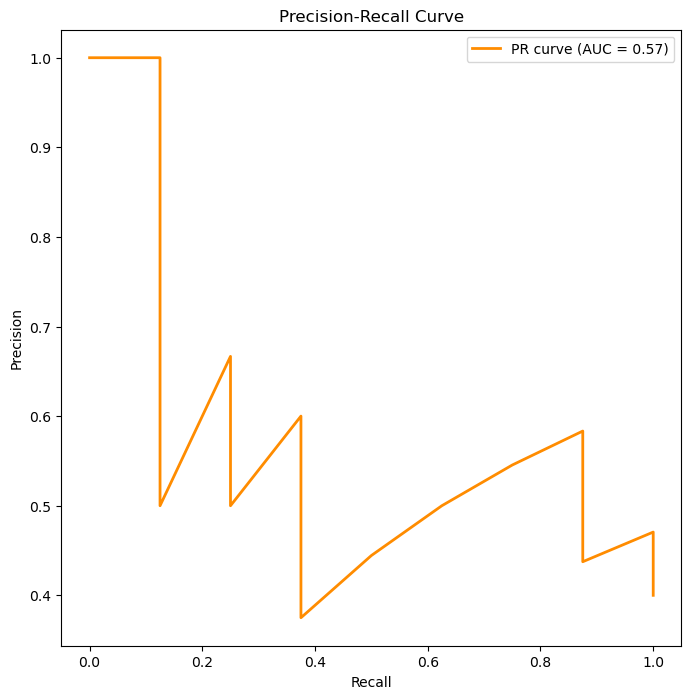

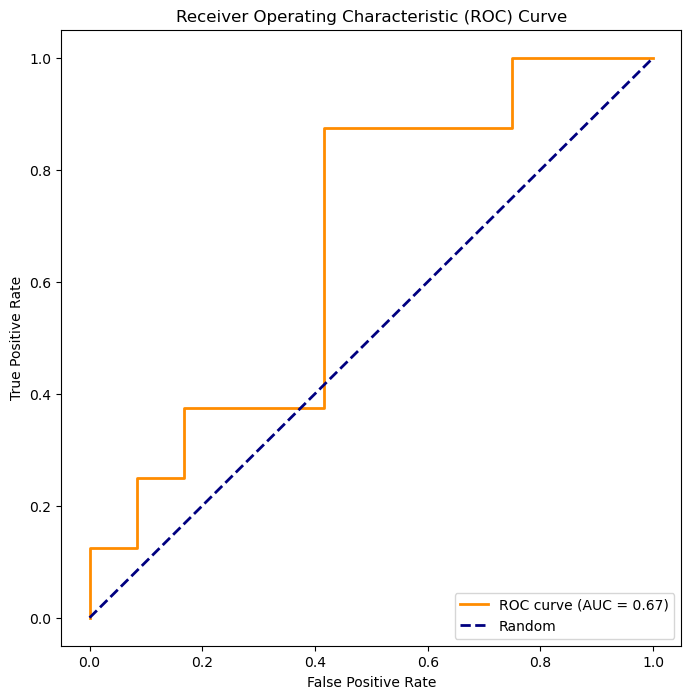

Log-Loss: 0.62


In [61]:
# Generating different evaluation metrics.
# Plotting the Confusion Matrix.
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

# Cohen's Kappa.
kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's Kappa: {kappa:.2f}")

# Matthews Correlation Coefficient (MCC).
mcc = matthews_corrcoef(y_test, predictions)
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

# Precision-Recall Curve.
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# ROC Curve.
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Log-Loss.
logloss = log_loss(y_test, y_prob)
print(f"Log-Loss: {logloss:.2f}")

Interpretation:

The confusion matrix indicates that the model correctly identifies a reasonable number of true negatives but struggles with false positives and false negatives.

Cohen's Kappa and Matthews Correlation Coefficient suggest fair to moderate agreement between predicted and actual classes, indicating that the model performs better than random chance but has room for improvement.

Consider further analyzing the specific characteristics of false positives and false negatives to identify areas for model improvement.

A Log-Loss of 0.62 suggests that, on average, the model's predicted probabilities are not well-calibrated with the true outcomes. A lower Log-Loss value would be desirable, indicating more accurate probability predictions.

In conclusion, the model 3 shows promise in predicting cardiac conditions based on the available features. However, there is room for improvement, particularly in enhancing the recall for positive instances. Further investigations, feature engineering, or adjustments to the modeling approach may be considered to refine the model's performance. Additionally, it is essential to interpret the results in the context of the specific objectives and consequences associated with false positives and false negatives in the prediction of cardiac conditions.